# Variational Autoencoder for Molecular graph images

This block

- imports all modules/libraries needed
- contains a function for a learning rate scheduler (if needed)
- reads in SMILES strings and creates a list
- featurizes via the SmilesTo Image featurizer from Deepchem (https://github.com/deepchem/deepchem)
- Four channel image used for featurization
  * Atomic numbers + bonds
  * partial charges
  * valence
  * hybridization

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import deepchem as dc
import time
from rdkit import Chem
from functools import partial
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, Draw
from sklearn.model_selection import train_test_split

def exp_decay(lr0,s):
    def exp_decay_fcn(epoch):
        return lr0*0.1**(epoch/s)
    return exp_decay_fcn

#df = pd.read_csv("392-azo.csv")
#df = pd.read_csv("212-azo.csv")
#df = pd.read_csv("604-azo.csv")
#df = pd.read_csv("621-azo.csv")
df = pd.read_csv("6731-azo.csv")

Xa = [""]*len(df)
w = [""]*len(df)
i=0
for name in df["SMILES"]:
    Xa[i]=name
    w[i]=1.0
    i += 1
Xa = list(Xa)
w=list(w)

#===========================================================================================
#featurizer

featurizer=dc.feat.SmilesToImage(img_spec="engd")
featname="SmilesToImage"

f = featurizer.featurize(Xa)
print("Number of features and datapoints: ",f.shape)

#===========================================================================================
print("featurization done with: ",featname)

# set npp for how many points in the dataset, len(df) for whole dataset
nnp=len(df)

#set y to lambdamax
y = df["Lmax"]

#set dataset and split

dataset = dc.data.NumpyDataset(X=f[:nnp,:,:,:], y=y[:nnp], ids=Xa[:nnp], w=w[:nnp])


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (C:\ProgramData\Anaconda3\envs\rdkitenv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Number of features and datapoints:  (6731, 80, 80, 4)
featurization done with:  SmilesToImage


## Plot original image versus image reconstructed with the model

- new_images function takes an image from the featurizer and runs it through the autoencoder
- resulting image is the reconstructed image from the model, showing the selected channel
- old_images takes the image from the featurizer and shows the selected channel
- options for rotation and cropping are also available in the above two functions
- plots original image on top, channel by channel, and reconstructed image on the bottom, channel by channel

1/1 [==============================] - 0s 43ms/step


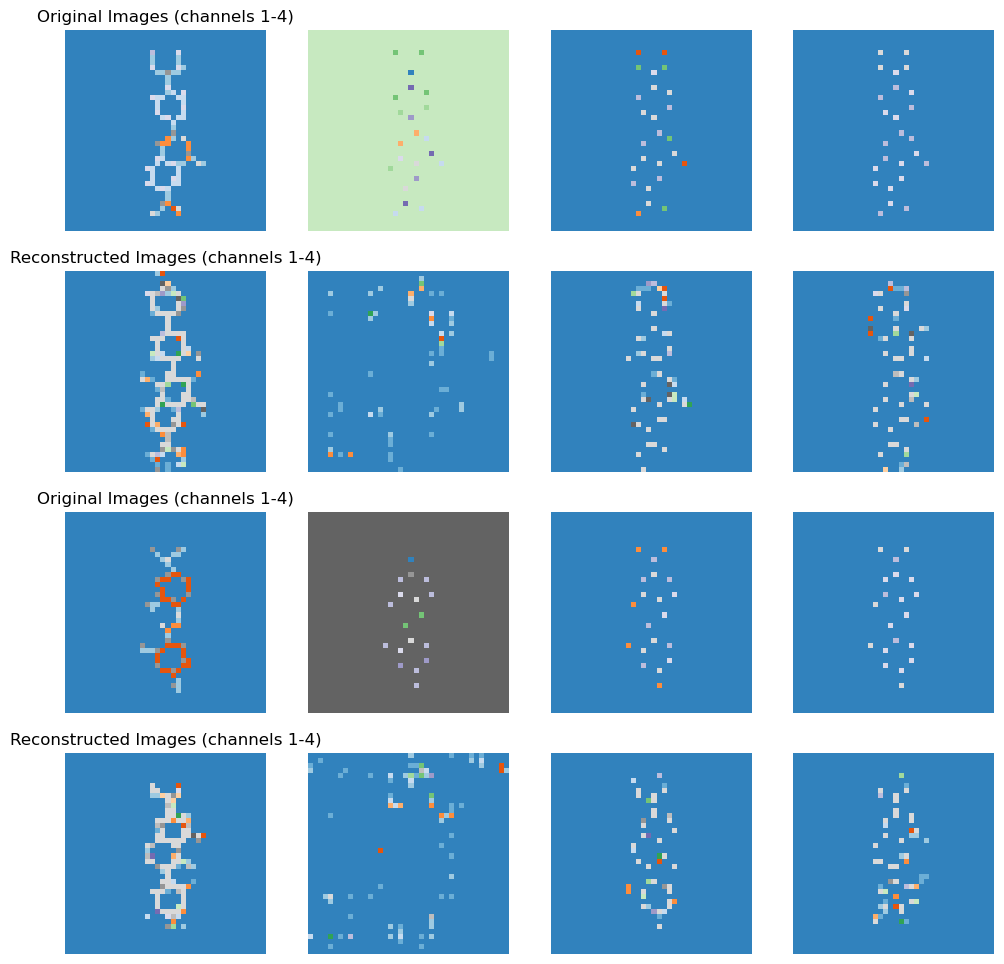

In [15]:
from matplotlib import pyplot as plt
from scipy import ndimage

#load a model
#autoencoder = tf.keras.models.load_model("6731_30March_test_autoencoder")


cmap="tab20c"

def new_images(model,image,channel):
    recons = model.predict(image)[0,:,:,channel] #last number cycles through channels 0-3
    rot = ndimage.rotate(recons, 0)
    rot = rot[20:60, 20:60]
    return rot

def old_images(model,image,channel):
    recons = image[0,:,:,channel] #last number cycles through channels 0-3
    rot = ndimage.rotate(recons, 0)
    rot  = rot[20:60, 20:60]
    return rot
    
m1=featurizer.featurize("[H]C1=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C1/N=N/C2=CC([H])=C(C=C2[H])N(CC)CC")
m2=featurizer.featurize("CC1=C(/N=N/C2=CC=C(N(C)C)C=C2C)C=CC(C)=C1")

newimages=[]
oldimages=[]
newimages2=[]
oldimages2=[]
for i in range(4):
    new1 = new_images(model=autoencoder,image=m1,channel=i)
    old1 = old_images(model=autoencoder,image=m1,channel=i)
    newimages.append(new1)
    oldimages.append(old1)
    new1 = new_images(model=autoencoder,image=m2,channel=i)
    old1 = old_images(model=autoencoder,image=m2,channel=i)
    newimages2.append(new1)
    oldimages2.append(old1)

#can insert scaling code here

fig, arrax = plt.subplots(4, 4, figsize=(12,12))
for i in range(4):
    arrax[0,i].imshow(oldimages[i],cmap=cmap)
    arrax[1,i].imshow(newimages[i],cmap=cmap)
    arrax[2,i].imshow(oldimages2[i],cmap=cmap)
    arrax[3,i].imshow(newimages2[i],cmap=cmap)
    arrax[0,i].axis("off")
    arrax[1,i].axis("off")
    arrax[2,i].axis("off")
    arrax[3,i].axis("off")
arrax[0,0].set_title("Original Images (channels 1-4)")
arrax[1,0].set_title("Reconstructed Images (channels 1-4)")
arrax[2,0].set_title("Original Images (channels 1-4)")
arrax[3,0].set_title("Reconstructed Images (channels 1-4)")

plt.show()

## Define the sampling layer

In [8]:
from keras import backend as K

class Sampling(tf.keras.layers.Layer):
    def call(self,inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5*z_log_var)*epsilon

## Variational Autoencoder

- uses Conv2D and MaxPooling in the encoder, Conv2DTranspose for the decoder
- 4 channel images from SmilesToImage from DeepChem
- regularization (l2) included and padding="same"
- borrows architechture from https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition

In [9]:
alphac = 0.0
embsize=128
epcs = 1

#=======================================================================================================
encoder_input = tf.keras.layers.Input(shape=[80,80,4], name = "encoder_input")
x = tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3), strides=2,padding="same",
                           kernel_regularizer=tf.keras.regularizers.l2(alphac))(encoder_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3), strides=2, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(alphac))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3), strides=2, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(alphac))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]
x = tf.keras.layers.Flatten()(x)

z_mean = tf.keras.layers.Dense(embsize,name = "z_mean")(x)
z_log_var = tf.keras.layers.Dense(embsize,name = "z_log_var")(x)
z = Sampling()([z_mean,z_log_var])

encoder = tf.keras.models.Model(encoder_input,[z_mean,z_log_var,z], name = "encoder")
#=======================================================================================================
decoder_input = tf.keras.layers.Input(shape=(embsize,), name = "decoder_input")
x = tf.keras.layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Reshape(shape_before_flattening)(x)
x = tf.keras.layers.Conv2DTranspose(filters=128,kernel_size=(3,3),strides=2, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(alphac))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(3,3),strides=2, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(alphac))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(3,3),strides=2, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(alphac))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
decoder_output = tf.keras.layers.Conv2D(4,kernel_size=(3,3),activation="sigmoid",padding="same",name="decoder_output")(x)

decoder = tf.keras.models.Model(decoder_input,decoder_output)
#=======================================================================================================
outputs = decoder(z)
autoencoder = tf.keras.models.Model(encoder_input,outputs)

# create loss for reconstruction plus the loss for the PDF for the embeddings ==========================

scale_ll = 1.0 / 16000.0
latent_loss_arg = -0.5 * tf.reduce_sum(1+ z_log_var - tf.exp(z_log_var)-tf.square(z_mean),axis=-1)
latent_loss = scale_ll * tf.reduce_mean(latent_loss_arg)
reconstruction_loss = tf.keras.losses.mean_squared_error(encoder_input,outputs)
vae_loss = K.mean(reconstruction_loss + latent_loss)
autoencoder.add_loss(vae_loss)

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(r"ConvAE/ConvAE",monitor="val_mse",save_best_only=True)
autoencoder.compile(optimizer=optimizer,metrics=["mse"])

history = autoencoder.fit(dataset.X,dataset.X,epochs=epcs,verbose=2,validation_split=0.1,callbacks=[checkpoint_cb])


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 30s - loss: 0.1881 - mse: 0.1828 - val_loss: 0.1847 - val_mse: 0.1848 - 30s/epoch - 157ms/step


## Generate new images

1/1 [==============================] - 0s 197ms/step
(2, 80, 80, 4)


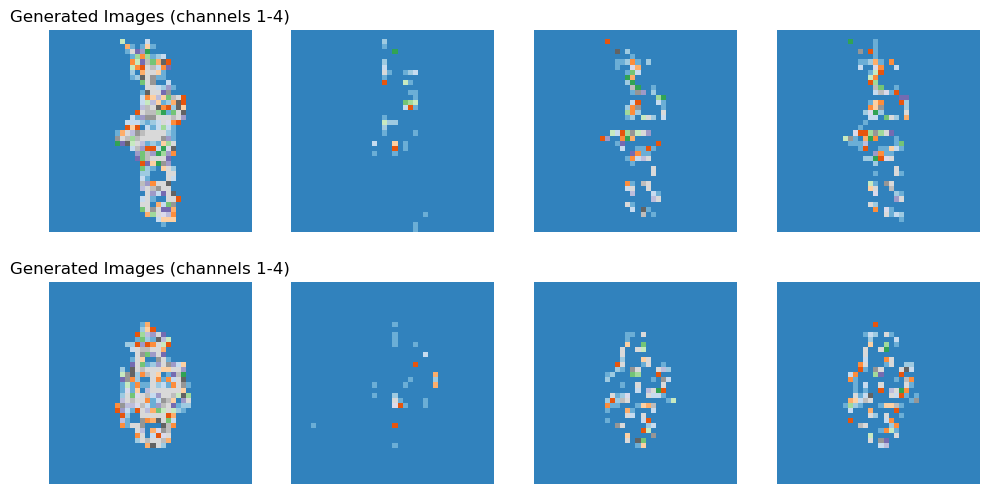

In [13]:
#load a model
#decoder = tf.keras.models.load_model("6731_30March_test_decoder")
#embsize=256

z_gen = np.random.normal(size=(2,embsize))

recons_embed = decoder.predict(z_gen)
print(recons_embed.shape)

from matplotlib import pyplot as plt
from scipy import ndimage

cmap="tab20c"

def new_images(image,channel):
    recons = image[:,:,channel] #last number cycles through channels 0-3
    rot = ndimage.rotate(recons, 0)
    rot  = rot[20:60, 20:60]
    return rot

newimages=[]
newimages2=[]
for i in range(4):
    new1 = new_images(image=recons_embed[0],channel=i)
    newimages.append(new1)
    new1 = new_images(image=recons_embed[1],channel=i)
    newimages2.append(new1)
    
#can insert scaling code here

fig, arrax = plt.subplots(2, 4, figsize=(12,6))
for i in range(4):
    arrax[0,i].imshow(newimages[i],cmap=cmap)
    arrax[1,i].imshow(newimages2[i],cmap=cmap)
    arrax[0,i].axis("off")
    arrax[1,i].axis("off")
arrax[0,0].set_title("Generated Images (channels 1-4)")
arrax[1,0].set_title("Generated Images (channels 1-4)")

plt.show()

## Save Convolutional Autoencoder

In [40]:
autoencoder.save("6731_31March_test",save_format="tf")
print("Autoencoder model saved.")

encoder.save("6731_31March_test_encoder",save_format="tf")
print("Encoder model saved.")

decoder.save("6731_31March_test_decoder",save_format="tf")
print("Decoder model saved.")

INFO:tensorflow:Assets written to: 6731_30March_test\assets


INFO:tensorflow:Assets written to: 6731_30March_test\assets


Autoencoder model saved.


INFO:tensorflow:Assets written to: 6731_30March_test_encoder\assets


INFO:tensorflow:Assets written to: 6731_30March_test_encoder\assets


Encoder model saved.


INFO:tensorflow:Assets written to: 6731_30March_test_decoder\assets


INFO:tensorflow:Assets written to: 6731_30March_test_decoder\assets


Decoder model saved.


## Load and restart training on the Convolutional Autoencoder

In [14]:
autoencoder = tf.keras.models.load_model("6731_30March_test")
epcs = 60

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer,metrics=["mse"])
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(r"ConvAE/ConvAE",monitor="val_mse",save_best_only=True)

history = autoencoder.fit(dataset.X,dataset.X,epochs=epcs+1,verbose=2,validation_split=0.1,initial_epoch=epcs,callbacks=[checkpoint_cb])

Epoch 61/61
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 43s - loss: 0.0554 - mse: 0.0517 - val_loss: 0.0538 - val_mse: 0.0510 - 43s/epoch - 226ms/step


## Visualize embedded distributions

1/1 [==============================] - 2s 2s/step
Plot a sample distribution from the input: 


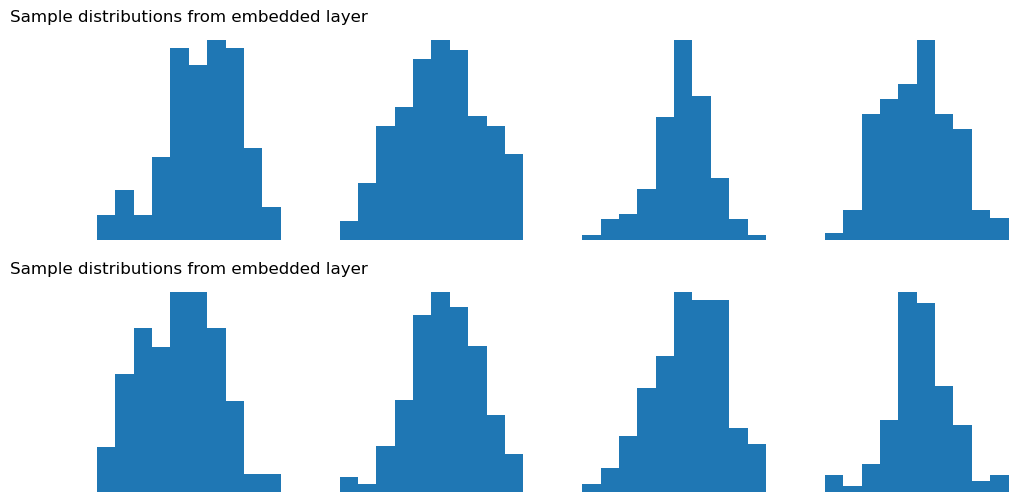

In [6]:
from matplotlib import pyplot as plt

#load a model
#encoder = tf.keras.models.load_model("6731_28March_50EPCS_encoder")

cmap="tab20c"

u1,u2,z_plot = encoder.predict(dataset.X[:8])
print("Plot a sample distribution from the input: ")

fig, arrax = plt.subplots(2, 4, figsize=(12,6))
for i in range(2):
    for j in range(4):
        arrax[i,j].hist(z_plot[i*4+j])
        arrax[i,j].axis("off")
        
arrax[0,0].set_title("Sample distributions from embedded layer")
arrax[1,0].set_title("Sample distributions from embedded layer")

plt.show()

## Code for scaling images

In [ ]:
#scaling for images
biggest, smallest = 0.0, 6000.0
tmp=np.empty(2)
for i in range(4):
    tmp[0] = newimages[i].max()
    tmp[1] = oldimages[i].max()
    tmps = tmp.max()
    if tmps > biggest:
        biggest = tmps
    tmp[0] = newimages[i].min()
    tmp[1] = oldimages[i].min()
    tmps = tmp.min()
    if tmps < smallest:
        smallest = tmps
scaled_newimages = ((newimages - smallest) * (1/(biggest-smallest)) * 255).astype('uint8')
scaled_oldimages = ((oldimages - smallest) * (1/(biggest-smallest)) * 255).astype('uint8')